<a href="https://colab.research.google.com/github/PaulRobertH/wine-ml-portfolio/blob/main/DP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [4]:
# Load the cleaned file you saved previously
df = pd.read_csv('/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv', index_col=0, parse_dates=True)


In [25]:
# Load cleaned dataset
df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

# Drop missing data just for safety
series = df['Liv-ex 100'].dropna()

# ✅ Filter out dates earlier than 2003
series = series[series.index >= '2004-01-01']

# Preview
series.tail()



,Liv-ex 100
2025-01-31,326.14
2025-02-28,323.51
2025-03-31,321.13
2025-04-30,315.70
2025-05-31,314.25


In [26]:
# Convert dates to ordinal numbers
X = series.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = series.values


In [27]:
# Capstone kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=50, length_scale_bounds=(1e-2, 1e4))

# Gaussian Process model
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)


In [28]:
# Fit the GP model to historical data
gp.fit(X, y)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=50),
                         n_restarts_optimizer=10, normalize_y=True)

In [29]:
# Create future dates
future_days = 365
last_date = series.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days, freq='D')
X_future = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)


In [30]:
import os
import pandas as pd

# Predict future prices
y_pred, sigma = gp.predict(X_future, return_std=True)

# Save predictions to DataFrame
df_forecast = pd.DataFrame({
    'Date': future_dates,
    'Livex100_Predicted': y_pred,
    'Livex100_Predicted_upper': y_pred + 2 * sigma,
    'Livex100_Predicted_lower': y_pred - 2 * sigma
})

# Save to CSV
os.makedirs('/content/drive/MyDrive/ML-Portfolio/data', exist_ok=True)
forecast_path = '/content/drive/MyDrive/ML-Portfolio/data/livex100_gp_forecast.csv'
df_forecast.to_csv(forecast_path, index=False)
print(f"✅ Forecast saved to: {forecast_path}")


✅ Forecast saved to: /content/drive/MyDrive/ML-Portfolio/data/livex100_gp_forecast.csv


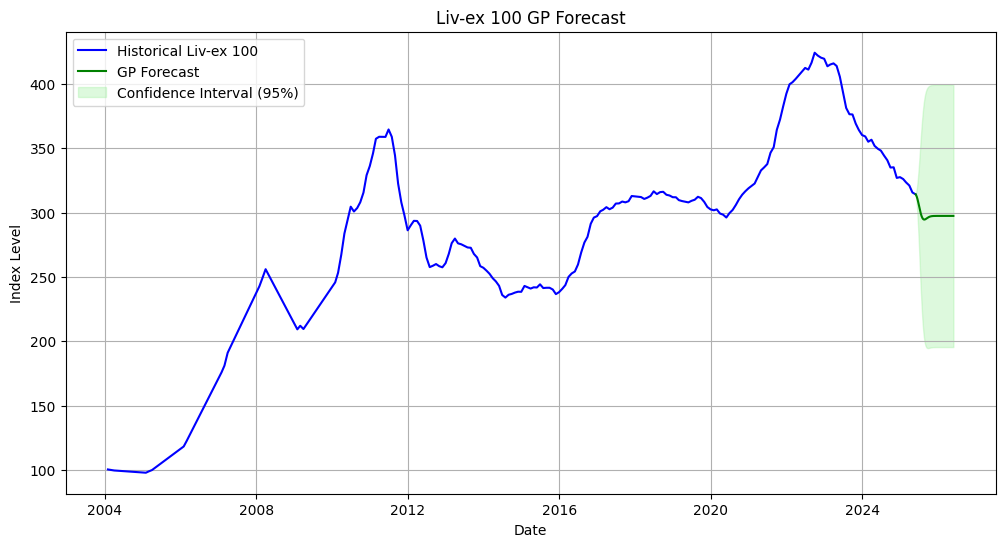

✅ Forecast plot saved to Images folder.


In [31]:
# Ensure images folder exists
os.makedirs("/content/drive/MyDrive/ML-Portfolio/Images", exist_ok=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(series.index, y, label='Historical Liv-ex 100', color='blue')
plt.plot(future_dates, y_pred, label='GP Forecast', color='green')
plt.fill_between(future_dates,
                 y_pred - 2 * sigma,
                 y_pred + 2 * sigma,
                 alpha=0.3,
                 color='lightgreen',
                 label='Confidence Interval (95%)')

plt.legend()
plt.title('Liv-ex 100 GP Forecast')
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid()

# Save figure
plt.savefig(
    '/content/drive/MyDrive/ML-Portfolio/Images/livex100_gp_forecast.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

print("✅ Forecast plot saved to Images folder.")
